[View in Colaboratory](https://colab.research.google.com/github/sbh69840/FLANN_lsh-mnist/blob/master/Signature_demo.ipynb)


# Signature Recognition and Verification (Off-line)

This is a demo of the paper "**Signature Recognition using invariant moments and Approximate Nearest Neighbors with LSH for signature verification to use this approach on the basis of a cloud computing architecture**" *- by Shivaraj B.H. *(Me)

> Since a sign plays a very important role in one's life, I have decided to create a demo of the above paper so that everyone reading this will easily be able to understand the way I have approached the problem in the paper. I have only used standard python libraries to implement the above algorithm and hope this gives a good result.

The dataset being used here is the[ UTSig dataset](https://www.semanticscholar.org/paper/UTSig%3A-A-Persian-Offline-Signature-Dataset-Soleimani-Fouladi/4b133ba6de9a7e1c7305c65eae34cde6ed34f8ce) which is publicly available.
So without any further due let's get started.![The image is copyright free and licensed under CC0 license](https://images.pexels.com/photos/48148/document-agreement-documents-sign-48148.jpeg?auto=compress&cs=tinysrgb&h=350&w=940)


In [3]:
#Install the required packages
!pip install pyflann
!pip install imutils

In [0]:
#import all the files here
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
import cv2
import imutils

# Three sample images 
These images are shown to show the preprocessing process because I can't upload the entire dataset which is around 250mb here (Takes a lot of time). Therefore, I am running the preprocess step locally and only displaying the steps on three images.

fatal: destination path 'UTSig' already exists and is not an empty directory.
('The shapes of the images in the order are : ', (1017, 860), (811, 1049), (463, 689))


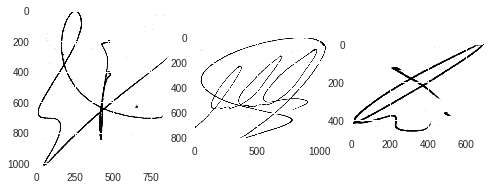

In [5]:
!git clone https://github.com/sbh69840/UTSig.git
#View the images
img = np.asarray(Image.open("UTSig/1.tif"))
img1 = np.asarray(Image.open("UTSig/2.tif"))
img2 = np.asarray(Image.open("UTSig/3.tif"))
plt.subplot(131)
plt.imshow(img,cmap = plt.get_cmap('gray'))
plt.subplot(132)
plt.imshow(img1,cmap = plt.get_cmap('gray'))
plt.subplot(133)
plt.imshow(img2,cmap = plt.get_cmap('gray'))
print("The shapes of the images in the order are : ",img.shape,img1.shape,img2.shape)


# Preprocessing Steps

The Steps that I thought I will be using for preprocessing are as follows :
1. RGB to gray 
2. Thresholding, so that the signature part is given more prominence than the background.
3. Reducing Noise in the image
4. Cropping and resizing the image to a desired size required for training.


Out of which 1,2,3 is done by the creators of the dataset so all that I have to worry is  resizing, but still I will try with thresholding once to check if it boosts the performance.
And since this domain involves finding the originality of signature I wouldn't want to manipulate the data too much and make the problem more confusing.

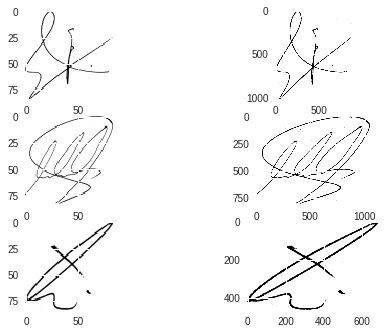

In [6]:
#cv2 is used to resize the image with INTER_AREA interpolation.
img_new = cv2.resize(img,(84,84),interpolation=cv2.INTER_AREA)
img1_new = cv2.resize(img1,(84,84),interpolation=cv2.INTER_AREA)
img2_new = cv2.resize(img2,(84,84),interpolation=cv2.INTER_AREA)
plt.subplot(321)
plt.imshow(img_new,cmap=plt.get_cmap('gray'))
plt.subplot(322)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.subplot(323)
plt.imshow(img1_new,cmap=plt.get_cmap('gray'))
plt.subplot(324)
plt.imshow(img1,cmap=plt.get_cmap('gray'))
plt.subplot(325)
plt.imshow(img2_new,cmap=plt.get_cmap('gray'))
plt.subplot(326)
plt.imshow(img2,cmap=plt.get_cmap('gray'))


# Thresholding Image
Just to see if the signature can be viewed more precisely.
As we can see the results below, there is no much difference when I view the original image and their threshold images respectively.

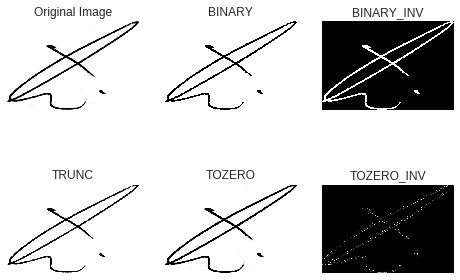

In [7]:

#The code credits goes to opencv website --> 
#https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
ret,thresh1 = cv2.threshold(img2,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img2,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img2,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img2,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img2,127,255,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img2, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in xrange(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

**But the view changes when I view the same threshold images of resized image and it seems that Torenzo gives a more clear picture of the image.**

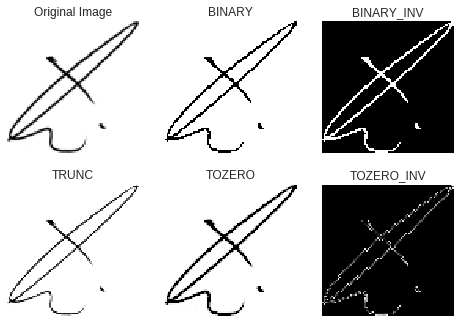

In [8]:

#The code credits goes to opencv website --> 
#https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
ret,thresh1 = cv2.threshold(img2_new,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img2_new,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img2_new,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img2_new,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img2_new,127,255,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img2_new, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in xrange(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

# Loading train and test data for Signature Recognition 
Since the dataset size was too big to add it here, I first preprocessed the entire dataset locally and then converted the train test dataset for signature recognition into compressed numpy array and uploaded it to github. 
Note : Compressed numpy array, i.e np.savez_compressed is better than storing using np.save becaue the latter one had a size of 178mb whereas compressed array has 6.5mb (That is a huge differrence)



> **The labels are already one-hot encoded and hence you don't have to do it.**



In [9]:
load = np.load("UTSig/train_test.npz")
X_train = load["X_train"]
y_train = load["y_train"]
X_test = load["X_test"]
y_test = load["y_test"]
print("The shapes of training and testing data are : ",X_train.shape,y_train.shape\
     ,X_test.shape,y_test.shape)

('The shapes of training and testing data are : ', (2328, 84, 84), (2328, 115), (777, 84, 84), (777, 115))


# Creating invariant moments for input layer
The above training and testing files are of images resized and since our recognition model uses invariant moments I will be using HUMoments method present in opencv whereas in the paper I am planning to not to use HUMoments but this paper, [*The revised fundamental theorem of moment invariants* ](https://ieeexplore.ieee.org/document/85675/), according to this paper the HUMoments are not absolutely correct and hence I wanted to implement that paper and find out if it is true, but since he says that most parts are correct and time constraints that I have now, I have to use the HUMoments, but as soon as I implement it I will update the code.
Steps to calculate the invariant moments: 


> rotate the image by 4 degree every time and calculate invariant moment every time and that will give you 90 features which can be used to train the neural network. FIrst I will be showing only demo on 3 images.

The equation for rotation of an image is :

\begin{bmatrix}x'\\y'\\\end{bmatrix}=\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \\\end{bmatrix}\begin{bmatrix}x\\y\\\end{bmatrix}



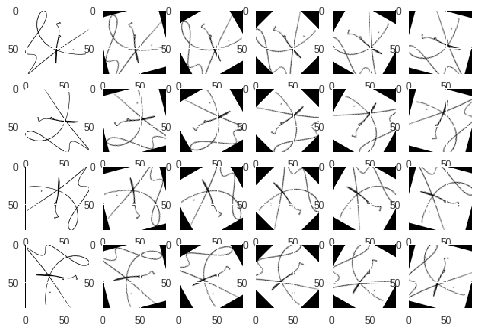

In [15]:
#Using imutils.rotate_bound to avoid the image being cut during normal rotate 
#as given by https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly
#-with-opencv-and-python/
#For rotation without bounds
#Some
for ind,angle in enumerate(np.arange(0, 360, 15)):
  rotated = imutils.rotate(img_new, angle)
  plt.subplot(4,6,ind+1)
  plt.imshow(rotated,cmap=plt.get_cmap("gray"))


(84, 84)
(102, 102)
(114, 114)
(118, 118)
(114, 114)
(102, 102)
(84, 84)
(102, 102)
(114, 114)
(118, 118)
(114, 114)
(102, 102)
(84, 84)
(102, 102)
(114, 114)
(118, 118)
(114, 114)
(102, 102)
(84, 84)
(102, 102)
(114, 114)
(118, 118)
(114, 114)
(102, 102)


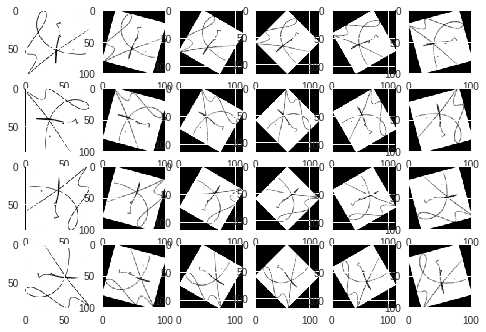

In [19]:
#For rotation with bounds
for ind,angle in enumerate(np.arange(0, 360, 15)):
  rotated = imutils.rotate_bound(img_new, angle)
  print(rotated.shape)
  plt.subplot(4,6,ind+1)
  plt.imshow(rotated,cmap=plt.get_cmap("gray"))

As can be seen above that it is better to use bounded rotation than normal rotation to not loose any detail of the signature on rotating.

# Calculating HU moments at every  4 degree for 1 sign

In [23]:

for ind,angle in enumerate(np.arange(0, 360, 4)):
  rotated = imutils.rotate_bound(img_new, angle)
  hu = cv2.HuMoments(cv2.moments(rotated)).flatten()
  print(hu)



[ 6.92131666e-04  7.99503111e-12  1.04492477e-13  2.55107180e-14
 -2.60649300e-28 -7.02389601e-20  1.29107573e-27]
[ 6.91586415e-04  7.09093348e-12  1.61295073e-13  1.97668385e-14
 -3.92111374e-28 -5.26081126e-20  1.04498994e-27]
[ 6.92043115e-04  8.02064292e-12  1.01884341e-13  2.58006110e-14
 -2.84998563e-28 -7.15959175e-20  1.29174769e-27]
[ 6.92036253e-04  6.92603736e-12  1.21253104e-13  2.31217041e-14
 -3.11685037e-28 -6.05076438e-20  1.18392671e-27]
[ 6.92054413e-04  6.64292399e-12  1.19768084e-13  2.33769932e-14
 -3.17242090e-28 -6.00114187e-20  1.19558040e-27]
[ 6.92157747e-04  6.95478403e-12  1.15037801e-13  2.41045839e-14
 -3.03090134e-28 -6.30375535e-20  1.23259863e-27]
[ 6.92288131e-04  8.06883883e-12  1.00582004e-13  2.60273725e-14
 -2.95932366e-28 -7.25332501e-20  1.29840004e-27]
[ 6.92196738e-04  6.91285430e-12  1.10082508e-13  2.49533375e-14
 -3.05578946e-28 -6.49559535e-20  1.27163175e-27]
[ 6.92165446e-04  6.40199585e-12  1.08952129e-13  2.42751881e-14
 -3.04684170e-2